In [74]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import ttest_ind

In [75]:
# Load the JSON data into a DataFrame
workouts = pd.read_json('workout.json')
workouts['date'] = pd.to_datetime(workouts['date'])

In [90]:
# Workouts data explode
exercise_data = workouts.explode('exercises').reset_index(drop=True)
exercise_data = pd.concat([exercise_data.drop(['exercises'], axis=1), exercise_data['exercises'].apply(pd.Series)], axis=1)

# Convert and handle NaNs
exercise_data['weight'] = pd.to_numeric(exercise_data['weight'], errors='coerce').fillna(0)
exercise_data['reps'] = pd.to_numeric(exercise_data['reps'], errors='coerce').fillna(0)
exercise_data['sets'] = pd.to_numeric(exercise_data['sets'], errors='coerce').fillna(0)

# Calculate total volume and add day of the week
exercise_data['total_volume'] = exercise_data['weight'] * exercise_data['sets'] * exercise_data['reps']
exercise_data['day_of_week'] = exercise_data['date'].dt.day_name()

# Progression for weight, reps, and sets for each exercise
selected_exercises = exercise_data['description'].unique()

# Basic Data Analysis


## Total Workout over time 

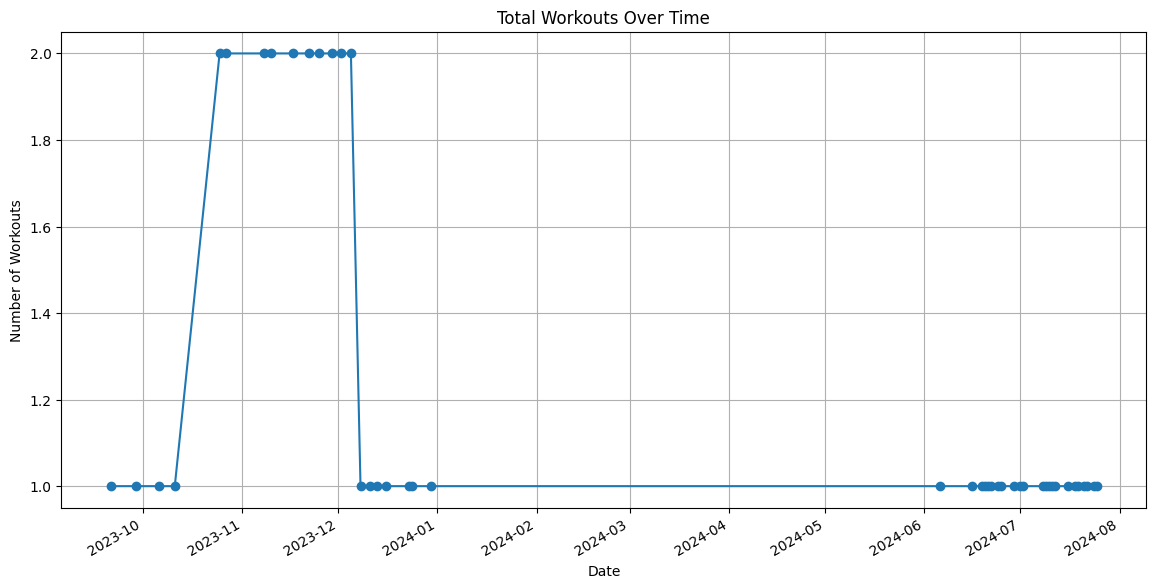

In [77]:
# Plot total workouts over time
plt.figure(figsize=(14, 7))
workouts['date'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Total Workouts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workouts')
plt.grid(True)
plt.show()

## Workout focus distribution 

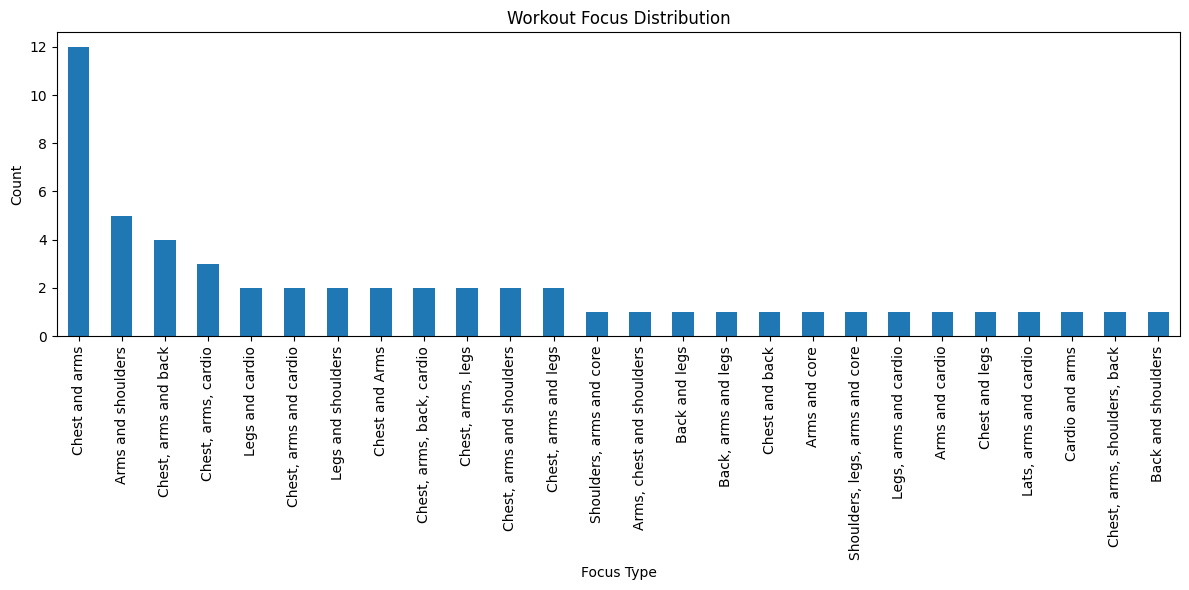

In [78]:
focus_counts = workouts['focus'].value_counts()

# Visualize the focus of workouts
plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
focus_counts.plot(kind='bar')
plt.title('Workout Focus Distribution')
plt.xlabel('Focus Type')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate labels to 90 degrees for better space management
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # Ensure one label per bar
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

## Total volume for bench press, bicep curl, squats

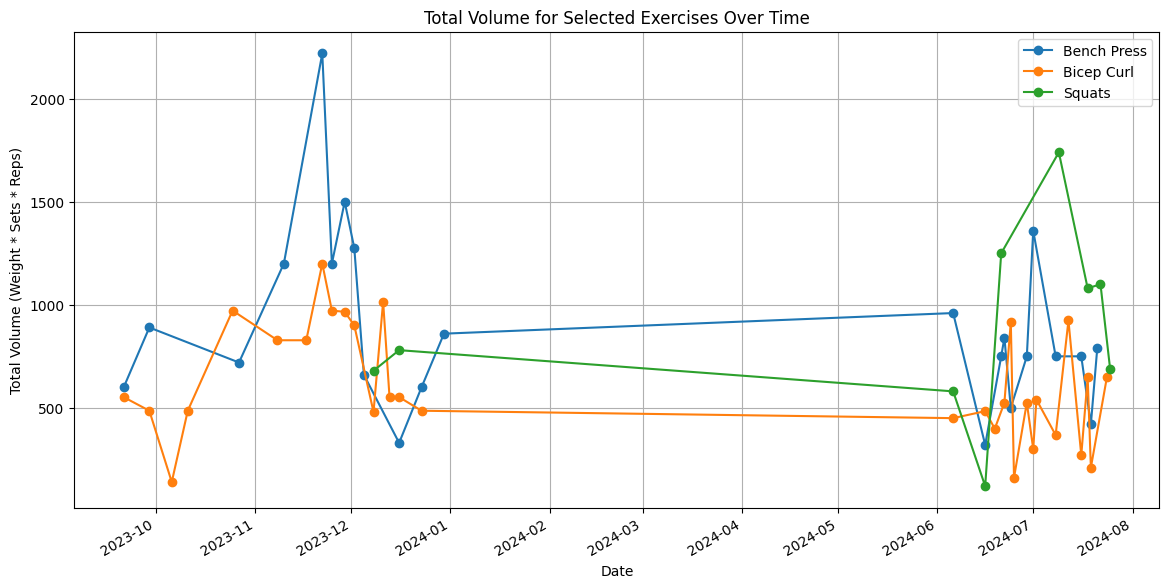

In [79]:
def calculate_volume(row):
    return row['weight'] * row['sets'] * row['reps']

# Filter for specific exercises and calculate volume
selected_exercises = ['Bench Press', 'Bicep Curl', 'Squats']
exercise_data = workouts.explode('exercises').reset_index(drop=True)
exercise_data = pd.concat([exercise_data.drop(['exercises'], axis=1), exercise_data['exercises'].apply(pd.Series)], axis=1)

exercise_volumes = exercise_data[exercise_data['description'].isin(selected_exercises)].copy()
exercise_volumes['total_volume'] = exercise_volumes.apply(calculate_volume, axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
for exercise in selected_exercises:
    subset = exercise_volumes[exercise_volumes['description'] == exercise]
    subset.groupby('date')['total_volume'].sum().plot(ax=ax, label=exercise, marker='o')

plt.title('Total Volume for Selected Exercises Over Time')
plt.xlabel('Date')
plt.ylabel('Total Volume (Weight * Sets * Reps)')
plt.legend()
plt.grid(True)
plt.show()


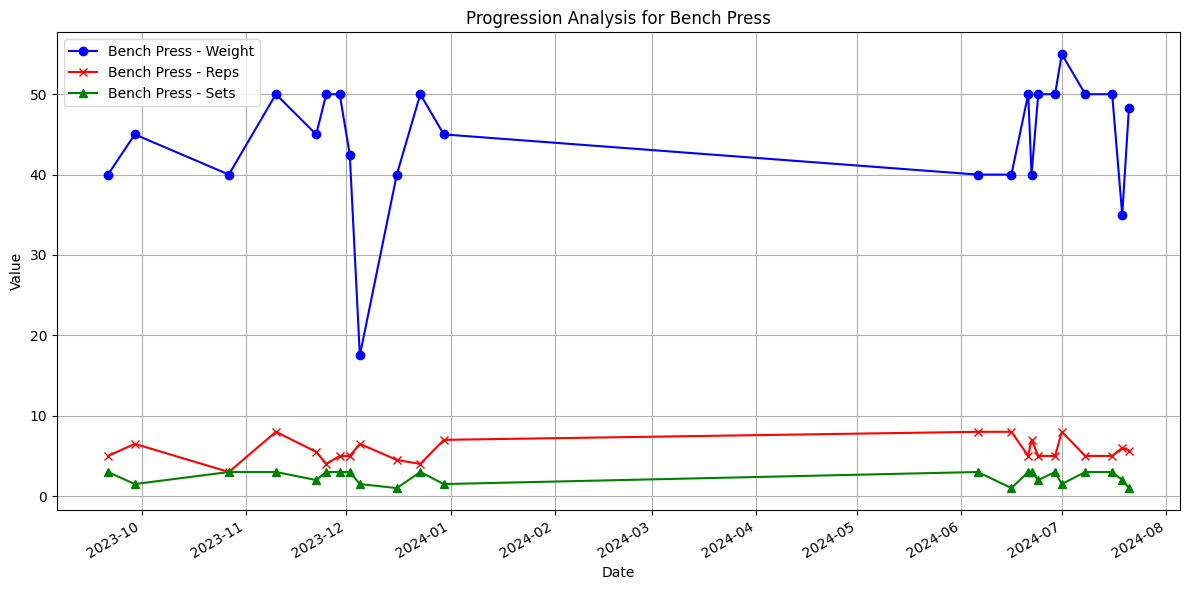

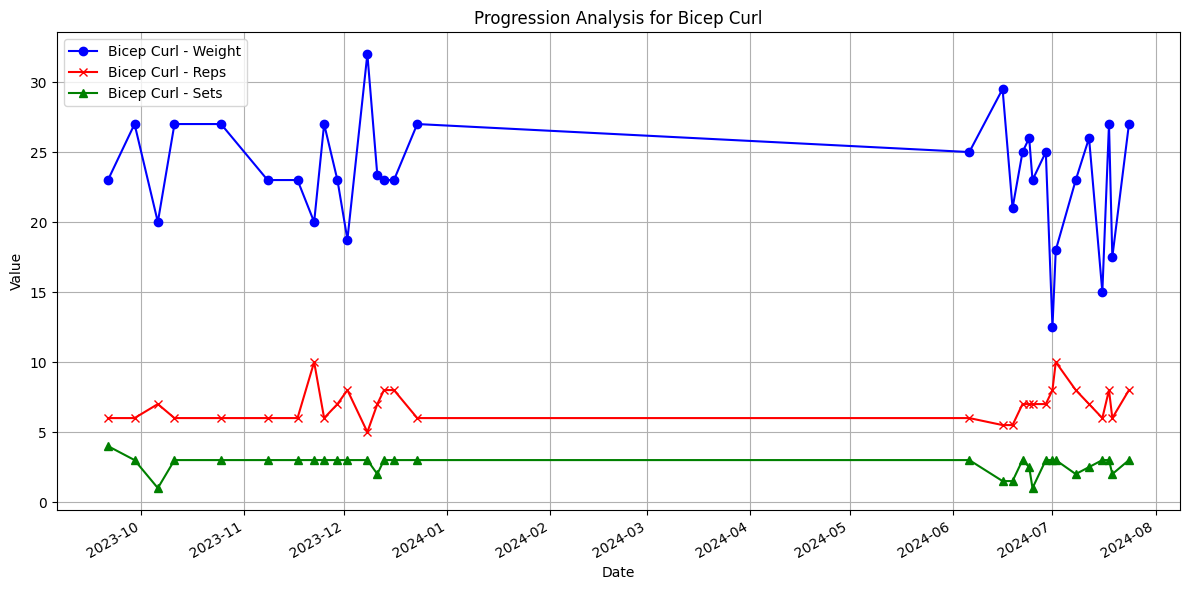

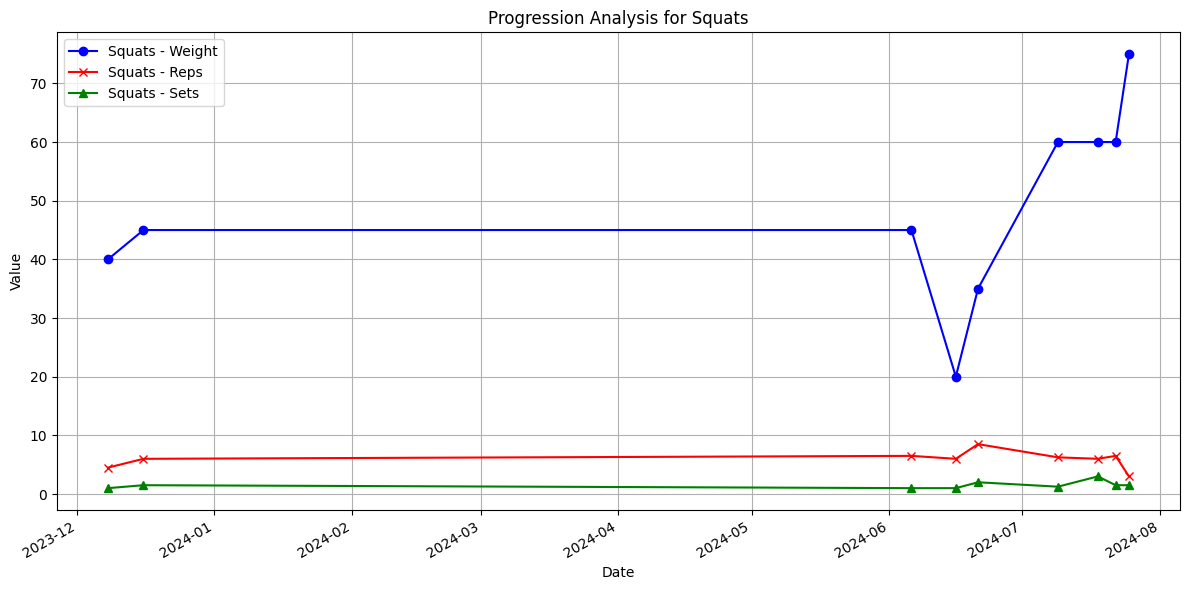

In [80]:
for exercise in selected_exercises:
    fig, ax = plt.subplots(figsize=(12, 6))
    subset = exercise_data[exercise_data['description'] == exercise]
    
    # Weight progression
    subset.groupby('date')['weight'].mean().plot(ax=ax, label=f'{exercise} - Weight', marker='o', color='blue')
    
    # Reps progression
    subset.groupby('date')['reps'].mean().plot(ax=ax, label=f'{exercise} - Reps', marker='x', color='red')
    
    # Sets progression
    subset.groupby('date')['sets'].mean().plot(ax=ax, label=f'{exercise} - Sets', marker='^', color='green')
    
    ax.set_title(f'Progression Analysis for {exercise}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Rate of Progression 

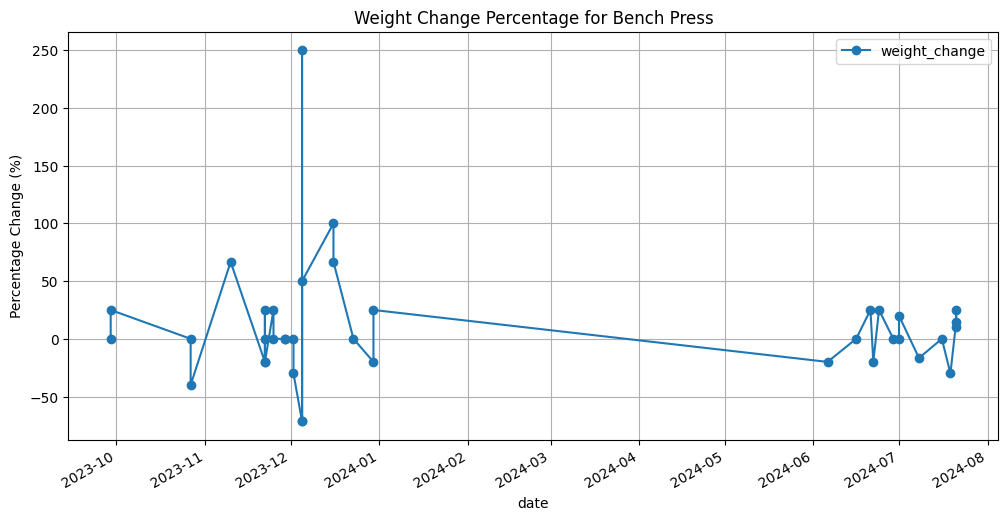

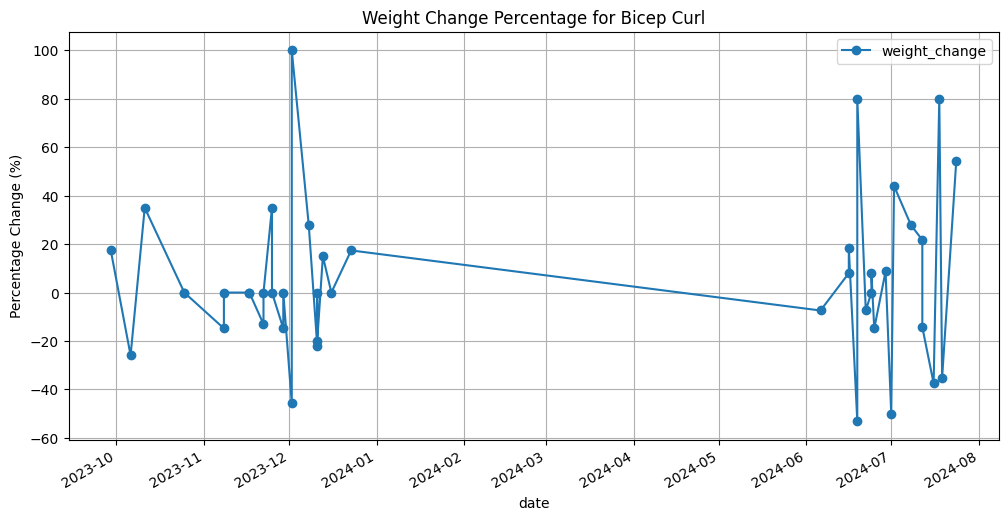

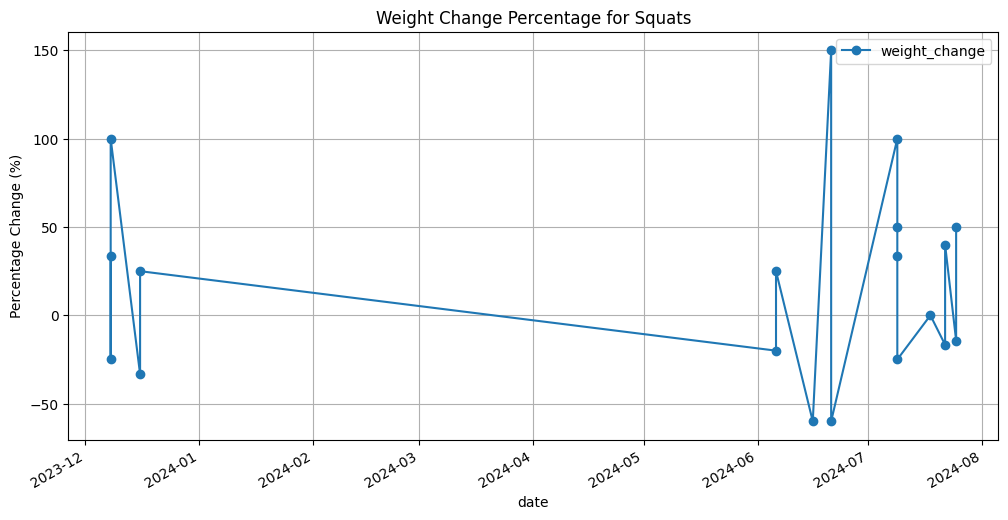

In [81]:
# Calculate the rate of progression for weight for each exercise
for exercise in selected_exercises:
    exercise_data_subset = exercise_data[exercise_data['description'] == exercise]
    exercise_data_subset = exercise_data_subset.sort_values('date')
    exercise_data_subset['weight_change'] = exercise_data_subset['weight'].pct_change() * 100
    fig, ax = plt.subplots(figsize=(12, 6))
    exercise_data_subset.plot(x='date', y='weight_change', ax=ax, marker='o', title=f'Weight Change Percentage for {exercise}')
    ax.set_ylabel('Percentage Change (%)')
    ax.grid(True)
    plt.show()


# Days between workouts 

<Figure size 1400x700 with 0 Axes>

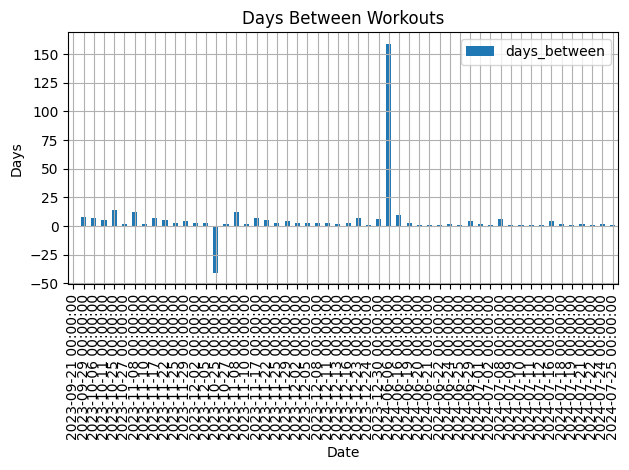

In [82]:
# Calculate days between workouts
workouts['previous_workout'] = workouts['date'].shift(1)
workouts['days_between'] = (workouts['date'] - workouts['previous_workout']).dt.days

# Plot days between workouts
plt.figure(figsize=(14, 7))
workouts.plot(x='date', y='days_between', kind='bar', title='Days Between Workouts')
plt.ylabel('Days')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()


# Analyzing Significant Changes

In [83]:
# Example: Test if the average volume in the first half of the period is different from the second half
first_half = exercise_volumes[exercise_volumes['date'] <= exercise_volumes['date'].median()]
second_half = exercise_volumes[exercise_volumes['date'] > exercise_volumes['date'].median()]

t_stat, p_val = ttest_ind(first_half['total_volume'], second_half['total_volume'])
print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: -0.611179410376587, P-value: 0.5424539318186832


# Heatmap for Weekly Activity

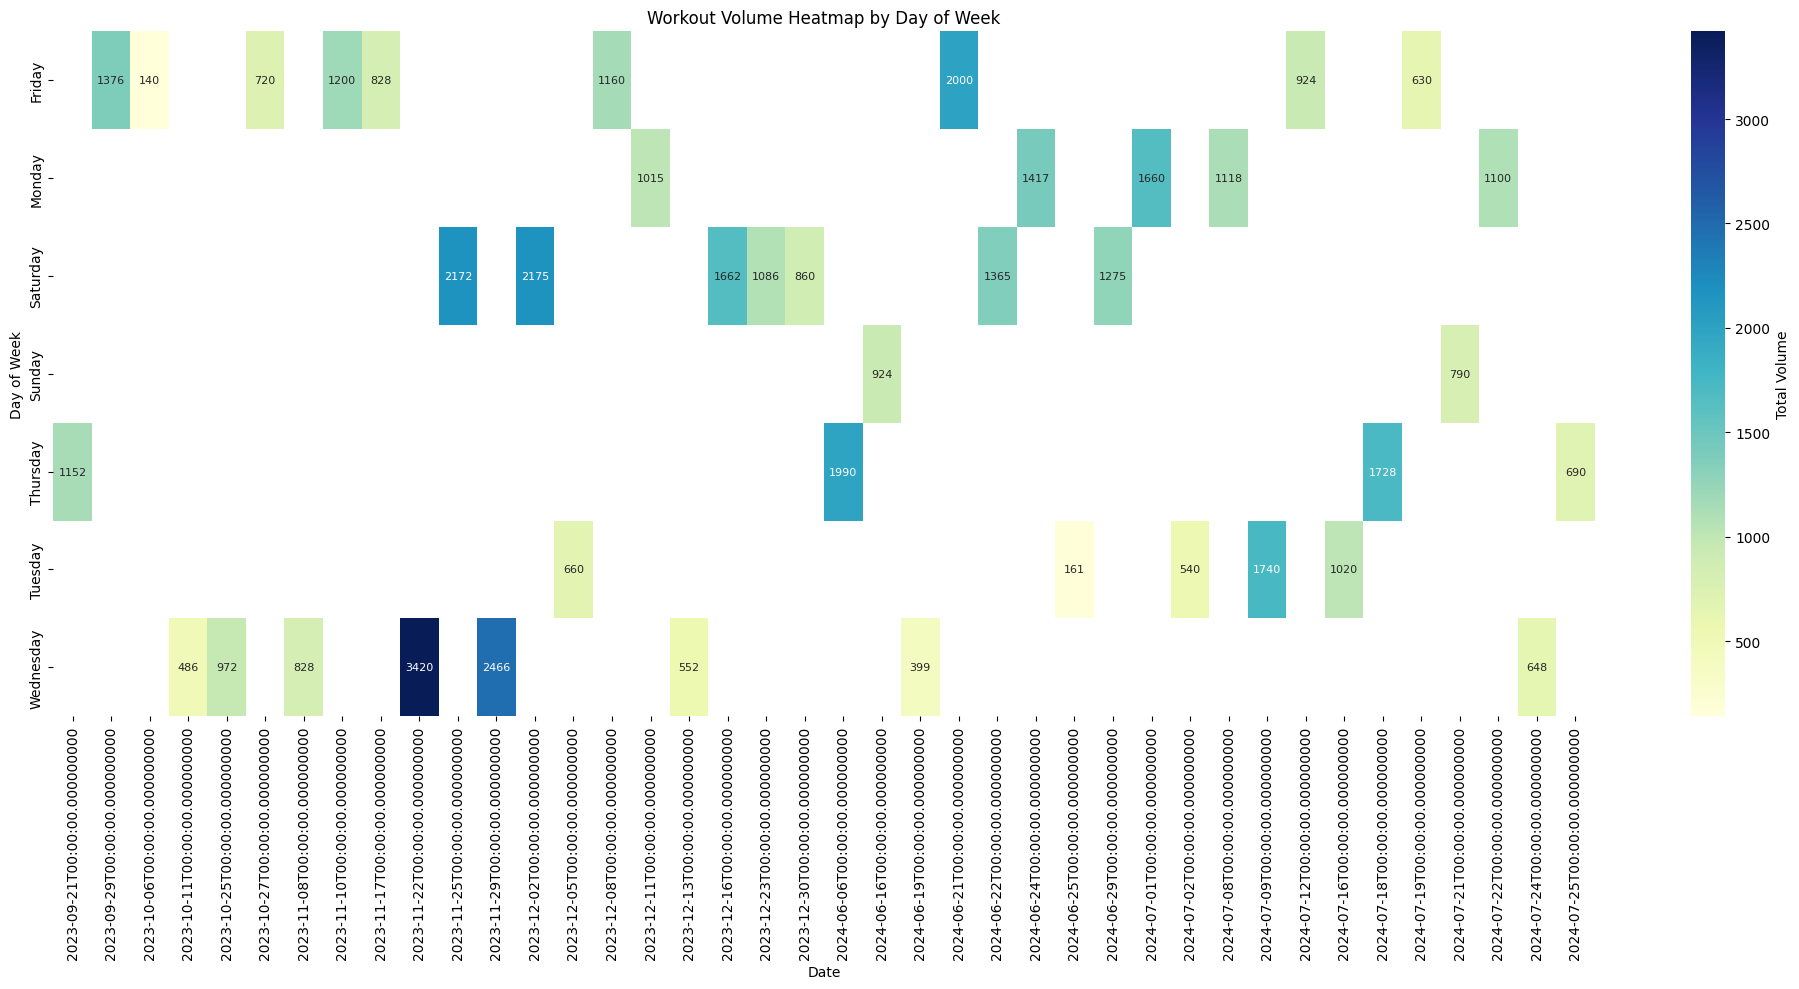

In [93]:
# Preparing data for heatmap
daily_volume = exercise_volumes.groupby(['day_of_week', 'date']).agg({'total_volume': 'sum'}).reset_index()
daily_volume_pivot = daily_volume.pivot(index='day_of_week', columns='date', values='total_volume')

# Plotting the heatmap
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
ax = sns.heatmap(daily_volume_pivot, cmap="YlGnBu", annot=True, fmt=".0f", annot_kws={'size':8})
plt.title('Workout Volume Heatmap by Day of Week')
plt.xlabel('Date')
plt.ylabel('Day of Week')

# Rotate date labels for better readability
plt.xticks(rotation=90)  # Rotate x labels for better visibility

# Adjust color bar size and location
colorbar = ax.collections[0].colorbar
colorbar.set_label('Total Volume')

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()
